In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pickle

from estimators.smi_estimator import compute_smi

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

### Load and Preprocess Dataset

In [39]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

def onehot_encode(image, label, n_classes):
    label = tf.one_hot(label, depth=n_classes)
    return image, label

def add_label_noise(ds, noise_ratio, n_classes, seed=seed):
    np.random.seed(seed)
    ds_numpy = list(ds.as_numpy_iterator())
    images, labels = zip(*ds_numpy)
    images = np.array(images)
    labels = np.array([np.argmax(label) for label in labels])  # Convert one-hot to integer labels

    n_samples = len(labels)
    n_noisy = int(n_samples * noise_ratio)
    noisy_indices = np.random.choice(n_samples, n_noisy, replace=False)
    
    for idx in noisy_indices:
        original_label = labels[idx]
        noisy_label = np.random.choice([l for l in range(n_classes) if l != original_label])
        labels[idx] = noisy_label
    
    labels = tf.one_hot(labels, depth=n_classes)  # Convert back to one-hot
    ds_noisy = tf.data.Dataset.from_tensor_slices((images, labels))
    
    return ds_noisy

(ds_train, ds_test), ds_info = tfds.load('mnist',
                                         split=['train', 'test'],
                                         data_dir = '../tensorflow_datasets/',
                                         shuffle_files=True,
                                         as_supervised=True,
                                         with_info=True,)
n_classes = ds_info.features['label'].num_classes
ds_train = ds_train.map(lambda x,y: normalize_img(x,y), num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(lambda x,y: onehot_encode(x,y,n_classes), num_parallel_calls=tf.data.AUTOTUNE)
ds_train_noisy_1 = add_label_noise(ds_train, noise_ratio=0.2, n_classes=n_classes, seed=seed)
ds_train_noisy_2 = add_label_noise(ds_train, noise_ratio=0.4, n_classes=n_classes, seed=seed)
ds_train = ds_train.batch(256).cache().prefetch(tf.data.AUTOTUNE)
ds_train_noisy_1 = ds_train_noisy_1.batch(256).cache().prefetch(tf.data.AUTOTUNE)
ds_train_noisy_2 = ds_train_noisy_2.batch(256).cache().prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(lambda x,y: normalize_img(x,y), num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(lambda x,y: onehot_encode(x,y,n_classes), num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(256).cache().prefetch(tf.data.AUTOTUNE)

### Create and Train Model (No Label Noise)

In [16]:
model = tf.keras.Sequential()
model.add(Flatten(input_shape=(ds_train.element_spec[0].shape[1:])))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(ds_train.element_spec[1].shape[1], activation='linear'))

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])

all_train_loss = []
all_train_acc = []
all_test_loss = []
all_test_acc = []

train_loss, train_acc = model.evaluate(ds_train)
test_loss, test_acc = model.evaluate(ds_test)

all_train_loss.append(train_loss)
all_train_acc.append(train_acc)
all_test_loss.append(test_loss)
all_test_acc.append(test_acc)

model.save('../results/SMI_Generalization/saved_models_0_label_noise/epoch_00.keras')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../results/SMI_Generalization/saved_models_0_label_noise/epoch_{epoch:02d}.keras',
    save_weights_only=False,
    save_best_only=False,
    verbose=1
)

history = model.fit(ds_train, verbose=1, epochs=50, validation_data=ds_test, callbacks=[model_checkpoint_callback])

all_train_loss.extend(history.history['loss'])
all_train_acc.extend(history.history['accuracy'])
all_test_loss.extend(history.history['val_loss'])
all_test_acc.extend(history.history['val_accuracy'])

40/40 [==============================] - 0s 6ms/step - loss: 2.3069 - accuracy: 0.0710
Epoch 1/50


2024-07-01 15:27:09.134627: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fbc652fddc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-01 15:27:09.134675: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-07-01 15:27:09.142865: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-01 15:27:09.197342: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90100
I0000 00:00:1719847629.300482 1854403 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 [==============================] - ETA: 0s - loss: 0.2276 - accuracy: 0.9294
Epoch 1: saving model to ../results/SMI_Generalization/saved_models_0_label_noise/epoch_01.keras
235/235 [==============================] - 3s 4ms/step - loss: 0.2276 - accuracy: 0.9294 - val_loss: 0.1034 - val_accuracy: 0.9700
Epoch 2/50
218/235 [==========================>...] - ETA: 0s - loss: 0.0809 - accuracy: 0.9756
Epoch 2: saving model to ../results/SMI_Generalization/saved_models_0_label_noise/epoch_02.keras
235/235 [==============================] - 1s 4ms/step - loss: 0.0799 - accuracy: 0.9759 - val_loss: 0.0981 - val_accuracy: 0.9705
Epoch 3/50
220/235 [===========================>..] - ETA: 0s - loss: 0.0576 - accuracy: 0.9824
Epoch 3: saving model to ../results/SMI_Generalization/saved_models_0_label_noise/epoch_03.keras
235/235 [==============================] - 1s 4ms/step - loss: 0.0576 - accuracy: 0.9824 - val_loss: 0.1025 - val_accuracy: 0.9719
Epoch 4/50
233/235 [===================

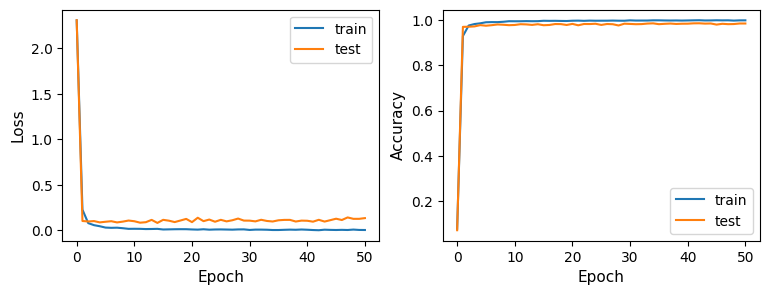

In [19]:
fig, axs =  plt.subplots(1, 2, figsize=(9, 3), dpi=100)
axs[0].plot(range(51), all_train_loss, c='tab:blue', label='train')
axs[0].plot(range(51), all_test_loss, c='tab:orange', label='test')
axs[0].legend(loc='upper right')
axs[0].set_xlabel('Epoch', fontsize=11)
axs[0].set_ylabel('Loss', fontsize=11)
axs[1].plot(range(51), all_train_acc, c='tab:blue', label='train')
axs[1].plot(range(51), all_test_acc, c='tab:orange', label='test')
axs[1].legend(loc='lower right')
axs[1].set_xlabel('Epoch', fontsize=11)
axs[1].set_ylabel('Accuracy', fontsize=11)
plt.show()

### Compute SMI (No Label Noise)

In [21]:
x_list = []
y_list = []
for x, y in ds_train:
    x_list.extend(x.numpy())
    y_list.extend(y.numpy())
    
saved_epoch_list = [epoch for epoch in range(51)
                    if (epoch <= 10 and epoch % 2 == 0) or
                    (10 < epoch <= 50 and epoch % 5 == 0)]

smi_all_epochs = []
for epoch in range(51):
    if epoch in saved_epoch_list:
        print(f'Epoch: {epoch:02}/51')
        smi_all_layers = []
        model = tf.keras.models.load_model(f"../results/SMI_Generalization/saved_models_0_label_noise/epoch_{epoch:02d}.keras")
        for l,layer in enumerate(model.layers):
            int_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[l].output)
            activity = int_model.predict(np.array(x_list[:1000]), verbose=0, batch_size=256)
            smi = compute_smi(activity, np.array(y_list[:1000]), proj_x=True, proj_y=False, n_projs=500, method='ksg_cd')
            smi_all_layers.append(smi)
            print(f'Layer {l}: SI(T;Y) = {smi:.3f}')
        smi_all_epochs.append(smi_all_layers)

Epoch: 00/51


Layer 0: SI(T;Y) = 0.153
Layer 1: SI(T;Y) = 0.135
Layer 2: SI(T;Y) = 0.120
Layer 3: SI(T;Y) = 0.113
Layer 4: SI(T;Y) = 0.106
Layer 5: SI(T;Y) = 0.103
Epoch: 02/51
Layer 0: SI(T;Y) = 0.154
Layer 1: SI(T;Y) = 0.216
Layer 2: SI(T;Y) = 0.424
Layer 3: SI(T;Y) = 0.709
Layer 4: SI(T;Y) = 0.867
Layer 5: SI(T;Y) = 1.060
Epoch: 04/51
Layer 0: SI(T;Y) = 0.151
Layer 1: SI(T;Y) = 0.217
Layer 2: SI(T;Y) = 0.439
Layer 3: SI(T;Y) = 0.762
Layer 4: SI(T;Y) = 0.921
Layer 5: SI(T;Y) = 1.117
Epoch: 06/51
Layer 0: SI(T;Y) = 0.152
Layer 1: SI(T;Y) = 0.202
Layer 2: SI(T;Y) = 0.425
Layer 3: SI(T;Y) = 0.764
Layer 4: SI(T;Y) = 0.945
Layer 5: SI(T;Y) = 1.121
Epoch: 08/51
Layer 0: SI(T;Y) = 0.149
Layer 1: SI(T;Y) = 0.207
Layer 2: SI(T;Y) = 0.429
Layer 3: SI(T;Y) = 0.801
Layer 4: SI(T;Y) = 0.962
Layer 5: SI(T;Y) = 1.145
Epoch: 10/51
Layer 0: SI(T;Y) = 0.148
Layer 1: SI(T;Y) = 0.197
Layer 2: SI(T;Y) = 0.411
Layer 3: SI(T;Y) = 0.778
Layer 4: SI(T;Y) = 0.955
Layer 5: SI(T;Y) = 1.125
Epoch: 15/51
Layer 0: SI(T;Y) = 0.1

In [24]:
results = {}
results['smi_all_epochs'] = smi_all_epochs

with open(f"../results/SMI_Generalization/smi_0_label_noise", 'wb') as f:
    pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)

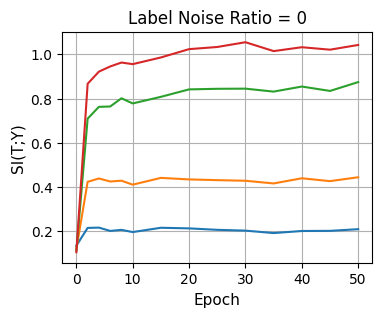

In [51]:
with open('../results/SMI_Generalization/smi_0_label_noise', 'rb') as f:
    results = pickle.load(f)
    
smi_all_epochs = results['smi_all_epochs']

saved_epoch_list = [epoch for epoch in range(51)
                    if (epoch <= 10 and epoch % 2 == 0) or
                    (10 < epoch <= 50 and epoch % 5 == 0)]

smi_layers = []
for layer in range(6):
    smi = []
    for epoch in range(len(saved_epoch_list)):
        smi.append(smi_all_epochs[epoch][layer])
    smi_layers.append(smi)
    
plt.figure(figsize=(4,3))
for layer in range(1,5):
    plt.plot(saved_epoch_list, smi_layers[layer])
plt.grid(True)
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('SI(T;Y)', fontsize=11)
plt.title('Label Noise Ratio = 0')
plt.show()

### Create and Train Model (0.2 Label Noise)

In [43]:
model = tf.keras.Sequential()
model.add(Flatten(input_shape=(ds_train.element_spec[0].shape[1:])))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(ds_train.element_spec[1].shape[1], activation='linear'))

In [44]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])

all_train_loss = []
all_train_acc = []
all_test_loss = []
all_test_acc = []

train_loss, train_acc = model.evaluate(ds_train_noisy_1)
test_loss, test_acc = model.evaluate(ds_test)

all_train_loss.append(train_loss)
all_train_acc.append(train_acc)
all_test_loss.append(test_loss)
all_test_acc.append(test_acc)

model.save('../results/SMI_Generalization/saved_models_0.2_label_noise/epoch_00.keras')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../results/SMI_Generalization/saved_models_0.2_label_noise/epoch_{epoch:02d}.keras',
    save_weights_only=False,
    save_best_only=False,
    verbose=1
)

history = model.fit(ds_train_noisy_1, verbose=1, epochs=50, validation_data=ds_test, callbacks=[model_checkpoint_callback])

all_train_loss.extend(history.history['loss'])
all_train_acc.extend(history.history['accuracy'])
all_test_loss.extend(history.history['val_loss'])
all_test_acc.extend(history.history['val_accuracy'])

40/40 [==============================] - 0s 1ms/step - loss: 2.3008 - accuracy: 0.1004
Epoch 1/50
229/235 [============================>.] - ETA: 0s - loss: 1.1450 - accuracy: 0.7378
Epoch 1: saving model to ../results/SMI_Generalization/saved_models_0.2_label_noise/epoch_01.keras
235/235 [==============================] - 2s 4ms/step - loss: 1.1424 - accuracy: 0.7386 - val_loss: 0.3232 - val_accuracy: 0.9603
Epoch 2/50
225/235 [===========================>..] - ETA: 0s - loss: 1.0185 - accuracy: 0.7778
Epoch 2: saving model to ../results/SMI_Generalization/saved_models_0.2_label_noise/epoch_02.keras
235/235 [==============================] - 1s 4ms/step - loss: 1.0182 - accuracy: 0.7779 - val_loss: 0.2945 - val_accuracy: 0.9641
Epoch 3/50
215/235 [==========================>...] - ETA: 0s - loss: 0.9753 - accuracy: 0.7864
Epoch 3: saving model to ../results/SMI_Generalization/saved_models_0.2_label_noise/epoch_03.keras
235/235 [==============================] - 1s 4ms/step - loss: 0.9

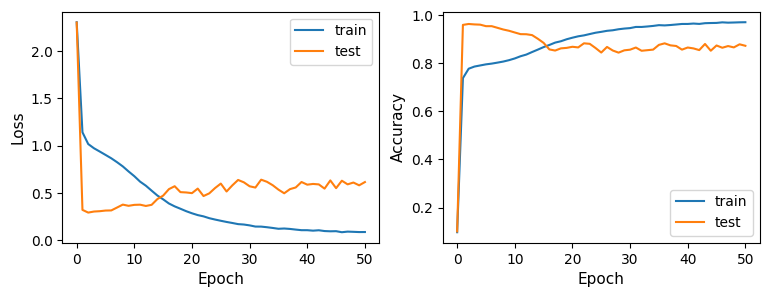

In [45]:
fig, axs =  plt.subplots(1, 2, figsize=(9, 3), dpi=100)
axs[0].plot(range(51), all_train_loss, c='tab:blue', label='train')
axs[0].plot(range(51), all_test_loss, c='tab:orange', label='test')
axs[0].legend(loc='upper right')
axs[0].set_xlabel('Epoch', fontsize=11)
axs[0].set_ylabel('Loss', fontsize=11)
axs[1].plot(range(51), all_train_acc, c='tab:blue', label='train')
axs[1].plot(range(51), all_test_acc, c='tab:orange', label='test')
axs[1].legend(loc='lower right')
axs[1].set_xlabel('Epoch', fontsize=11)
axs[1].set_ylabel('Accuracy', fontsize=11)
plt.show()

### Compute SMI (0.2 Label Noise)

In [62]:
x_list = []
y_list = []
for x, y in ds_train_noisy_1:
    x_list.extend(x.numpy())
    y_list.extend(y.numpy())
    
saved_epoch_list = [epoch for epoch in range(51)
                    if (epoch <= 10 and epoch % 2 == 0) or
                    (10 < epoch <= 50 and epoch % 5 == 0)]

smi_all_epochs = []
for epoch in range(51):
    if epoch in saved_epoch_list:
        print(f'Epoch: {epoch:02}/51')
        smi_all_layers = []
        model = tf.keras.models.load_model(f"../results/SMI_Generalization/saved_models_0.2_label_noise/epoch_{epoch:02d}.keras")
        for l,layer in enumerate(model.layers):
            int_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[l].output)
            activity = int_model.predict(np.array(x_list[:10000]), verbose=0, batch_size=256)
            smi = compute_smi(activity, np.array(y_list[:10000]), proj_x=True, proj_y=False, n_projs=500, method='ksg_cd')
            smi_all_layers.append(smi)
            print(f'Layer {l}: SI(T;Y) = {smi:.3f}')
        smi_all_epochs.append(smi_all_layers)

Epoch: 00/51
Layer 0: SI(T;Y) = 0.087
Layer 1: SI(T;Y) = 0.075
Layer 2: SI(T;Y) = 0.068
Layer 3: SI(T;Y) = 0.064
Layer 4: SI(T;Y) = 0.060
Layer 5: SI(T;Y) = 0.060
Epoch: 02/51
Layer 0: SI(T;Y) = 0.084
Layer 1: SI(T;Y) = 0.117
Layer 2: SI(T;Y) = 0.261
Layer 3: SI(T;Y) = 0.443
Layer 4: SI(T;Y) = 0.597
Layer 5: SI(T;Y) = 0.728
Epoch: 04/51
Layer 0: SI(T;Y) = 0.085
Layer 1: SI(T;Y) = 0.110
Layer 2: SI(T;Y) = 0.212
Layer 3: SI(T;Y) = 0.384
Layer 4: SI(T;Y) = 0.554
Layer 5: SI(T;Y) = 0.690
Epoch: 06/51
Layer 0: SI(T;Y) = 0.083
Layer 1: SI(T;Y) = 0.102
Layer 2: SI(T;Y) = 0.157
Layer 3: SI(T;Y) = 0.293
Layer 4: SI(T;Y) = 0.427
Layer 5: SI(T;Y) = 0.542
Epoch: 08/51
Layer 0: SI(T;Y) = 0.086
Layer 1: SI(T;Y) = 0.094
Layer 2: SI(T;Y) = 0.134
Layer 3: SI(T;Y) = 0.234
Layer 4: SI(T;Y) = 0.334
Layer 5: SI(T;Y) = 0.423
Epoch: 10/51
Layer 0: SI(T;Y) = 0.085
Layer 1: SI(T;Y) = 0.086
Layer 2: SI(T;Y) = 0.114
Layer 3: SI(T;Y) = 0.199
Layer 4: SI(T;Y) = 0.291
Layer 5: SI(T;Y) = 0.361
Epoch: 15/51
Layer 0: 

In [63]:
results = {}
results['smi_all_epochs'] = smi_all_epochs

with open(f"../results/SMI_Generalization/smi_0.2_label_noise", 'wb') as f:
    pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)

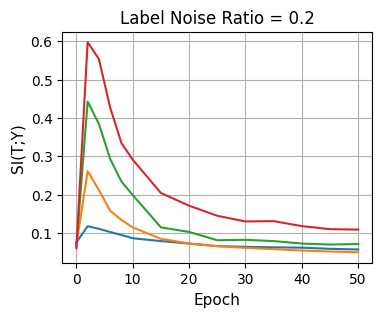

In [64]:
with open('../results/SMI_Generalization/smi_0.2_label_noise', 'rb') as f:
    results = pickle.load(f)
    
smi_all_epochs = results['smi_all_epochs']

saved_epoch_list = [epoch for epoch in range(51)
                    if (epoch <= 10 and epoch % 2 == 0) or
                    (10 < epoch <= 50 and epoch % 5 == 0)]

smi_layers = []
for layer in range(6):
    smi = []
    for epoch in range(len(saved_epoch_list)):
        smi.append(smi_all_epochs[epoch][layer])
    smi_layers.append(smi)
    
plt.figure(figsize=(4,3))
for layer in range(1,5):
    plt.plot(saved_epoch_list, smi_layers[layer])
plt.grid(True)
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('SI(T;Y)', fontsize=11)
plt.title('Label Noise Ratio = 0.2')
plt.show()

### Create and Train Model (0.4 Label Noise)

In [54]:
model = tf.keras.Sequential()
model.add(Flatten(input_shape=(ds_train.element_spec[0].shape[1:])))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(ds_train.element_spec[1].shape[1], activation='linear'))

In [55]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])

all_train_loss = []
all_train_acc = []
all_test_loss = []
all_test_acc = []

train_loss, train_acc = model.evaluate(ds_train_noisy_2)
test_loss, test_acc = model.evaluate(ds_test)

all_train_loss.append(train_loss)
all_train_acc.append(train_acc)
all_test_loss.append(test_loss)
all_test_acc.append(test_acc)

model.save('../results/SMI_Generalization/saved_models_0.4_label_noise/epoch_00.keras')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../results/SMI_Generalization/saved_models_0.4_label_noise/epoch_{epoch:02d}.keras',
    save_weights_only=False,
    save_best_only=False,
    verbose=1
)

history = model.fit(ds_train_noisy_2, verbose=1, epochs=50, validation_data=ds_test, callbacks=[model_checkpoint_callback])

all_train_loss.extend(history.history['loss'])
all_train_acc.extend(history.history['accuracy'])
all_test_loss.extend(history.history['val_loss'])
all_test_acc.extend(history.history['val_accuracy'])

40/40 [==============================] - 0s 1ms/step - loss: 2.3072 - accuracy: 0.0893
Epoch 1/50
222/235 [===========================>..] - ETA: 0s - loss: 1.7051 - accuracy: 0.5464
Epoch 1: saving model to ../results/SMI_Generalization/saved_models_0.4_label_noise/epoch_01.keras
235/235 [==============================] - 3s 4ms/step - loss: 1.7030 - accuracy: 0.5473 - val_loss: 0.7233 - val_accuracy: 0.9443
Epoch 2/50
229/235 [============================>.] - ETA: 0s - loss: 1.6121 - accuracy: 0.5787
Epoch 2: saving model to ../results/SMI_Generalization/saved_models_0.4_label_noise/epoch_02.keras
235/235 [==============================] - 1s 4ms/step - loss: 1.6121 - accuracy: 0.5787 - val_loss: 0.6638 - val_accuracy: 0.9547
Epoch 3/50
216/235 [==========================>...] - ETA: 0s - loss: 1.5747 - accuracy: 0.5871
Epoch 3: saving model to ../results/SMI_Generalization/saved_models_0.4_label_noise/epoch_03.keras
235/235 [==============================] - 1s 4ms/step - loss: 1.5

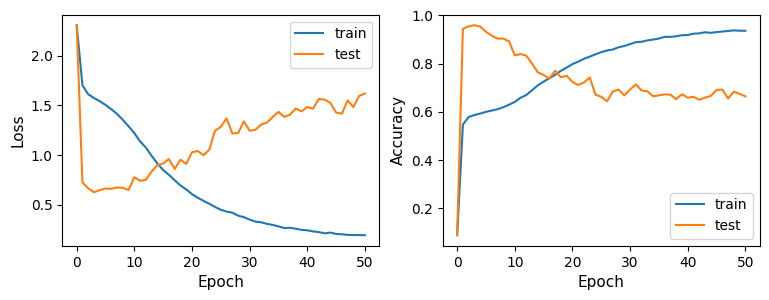

In [56]:
fig, axs =  plt.subplots(1, 2, figsize=(9, 3), dpi=100)
axs[0].plot(range(51), all_train_loss, c='tab:blue', label='train')
axs[0].plot(range(51), all_test_loss, c='tab:orange', label='test')
axs[0].legend(loc='upper right')
axs[0].set_xlabel('Epoch', fontsize=11)
axs[0].set_ylabel('Loss', fontsize=11)
axs[1].plot(range(51), all_train_acc, c='tab:blue', label='train')
axs[1].plot(range(51), all_test_acc, c='tab:orange', label='test')
axs[1].legend(loc='lower right')
axs[1].set_xlabel('Epoch', fontsize=11)
axs[1].set_ylabel('Accuracy', fontsize=11)
plt.show()

### Compute SMI (0.4 Label Noise)

In [58]:
x_list = []
y_list = []
for x, y in ds_train_noisy_2:
    x_list.extend(x.numpy())
    y_list.extend(y.numpy())
    
saved_epoch_list = [epoch for epoch in range(51)
                    if (epoch <= 10 and epoch % 2 == 0) or
                    (10 < epoch <= 50 and epoch % 5 == 0)]

smi_all_epochs = []
for epoch in range(51):
    if epoch in saved_epoch_list:
        print(f'Epoch: {epoch:02}/51')
        smi_all_layers = []
        model = tf.keras.models.load_model(f"../results/SMI_Generalization/saved_models_0.4_label_noise/epoch_{epoch:02d}.keras")
        for l,layer in enumerate(model.layers):
            int_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[l].output)
            activity = int_model.predict(np.array(x_list[:10000]), verbose=0, batch_size=256)
            smi = compute_smi(activity, np.array(y_list[:10000]), proj_x=True, proj_y=False, n_projs=500, method='ksg_cd')
            smi_all_layers.append(smi)
            print(f'Layer {l}: SI(T;Y) = {smi:.3f}')
        smi_all_epochs.append(smi_all_layers)

Epoch: 00/51
Layer 0: SI(T;Y) = 0.041
Layer 1: SI(T;Y) = 0.037
Layer 2: SI(T;Y) = 0.032
Layer 3: SI(T;Y) = 0.031
Layer 4: SI(T;Y) = 0.030
Layer 5: SI(T;Y) = 0.030
Epoch: 02/51
Layer 0: SI(T;Y) = 0.043
Layer 1: SI(T;Y) = 0.068
Layer 2: SI(T;Y) = 0.137
Layer 3: SI(T;Y) = 0.229
Layer 4: SI(T;Y) = 0.313
Layer 5: SI(T;Y) = 0.388
Epoch: 04/51
Layer 0: SI(T;Y) = 0.042
Layer 1: SI(T;Y) = 0.058
Layer 2: SI(T;Y) = 0.104
Layer 3: SI(T;Y) = 0.186
Layer 4: SI(T;Y) = 0.275
Layer 5: SI(T;Y) = 0.352
Epoch: 06/51
Layer 0: SI(T;Y) = 0.041
Layer 1: SI(T;Y) = 0.049
Layer 2: SI(T;Y) = 0.077
Layer 3: SI(T;Y) = 0.129
Layer 4: SI(T;Y) = 0.195
Layer 5: SI(T;Y) = 0.255
Epoch: 08/51
Layer 0: SI(T;Y) = 0.043
Layer 1: SI(T;Y) = 0.048
Layer 2: SI(T;Y) = 0.059
Layer 3: SI(T;Y) = 0.098
Layer 4: SI(T;Y) = 0.153
Layer 5: SI(T;Y) = 0.205
Epoch: 10/51
Layer 0: SI(T;Y) = 0.041
Layer 1: SI(T;Y) = 0.045
Layer 2: SI(T;Y) = 0.053
Layer 3: SI(T;Y) = 0.070
Layer 4: SI(T;Y) = 0.112
Layer 5: SI(T;Y) = 0.155
Epoch: 15/51
Layer 0: 

In [59]:
results = {}
results['smi_all_epochs'] = smi_all_epochs

with open(f"../results/SMI_Generalization/smi_0.4_label_noise", 'wb') as f:
    pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)

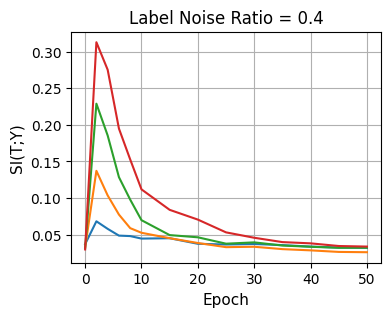

In [60]:
with open('../results/SMI_Generalization/smi_0.4_label_noise', 'rb') as f:
    results = pickle.load(f)
    
smi_all_epochs = results['smi_all_epochs']

saved_epoch_list = [epoch for epoch in range(51)
                    if (epoch <= 10 and epoch % 2 == 0) or
                    (10 < epoch <= 50 and epoch % 5 == 0)]

smi_layers = []
for layer in range(6):
    smi = []
    for epoch in range(len(saved_epoch_list)):
        smi.append(smi_all_epochs[epoch][layer])
    smi_layers.append(smi)
    
plt.figure(figsize=(4,3))
for layer in range(1,5):
    plt.plot(saved_epoch_list, smi_layers[layer])
plt.grid(True)
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('SI(T;Y)', fontsize=11)
plt.title('Label Noise Ratio = 0.4')
plt.show()

### Plots

In [68]:
all_train_loss = []
all_test_loss = []
all_train_acc = []
all_test_acc = []

saved_epoch_list = [epoch for epoch in range(51)
                    if (epoch <= 10 and epoch % 2 == 0) or
                    (10 < epoch <= 50 and epoch % 5 == 0)]

for label_noise in [0,0.2,0.4]:
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    for epoch in range(51):
        if epoch in saved_epoch_list:
            model = tf.keras.models.load_model(f"../results/SMI_Generalization/saved_models_{label_noise}_label_noise/epoch_{epoch:02d}.keras")
            loss, acc = model.evaluate(ds_train, verbose=0)
            train_loss.append(loss)
            train_acc.append(acc)
            loss, acc = model.evaluate(ds_test, verbose=0)
            test_loss.append(loss)
            test_acc.append(acc)
    all_train_loss.append(train_loss)
    all_test_loss.append(test_loss)
    all_train_acc.append(train_acc)
    all_test_acc.append(test_acc)

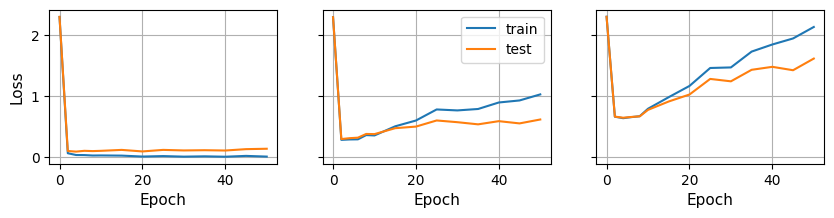

In [79]:
fig, axs =  plt.subplots(1, 3, figsize=(10, 2), dpi=100, sharey=True)
axs[0].plot(saved_epoch_list, all_train_loss[0], c='tab:blue', label='train')
axs[0].plot(saved_epoch_list, all_test_loss[0], c='tab:orange', label='test')
axs[0].set_xlabel('Epoch', fontsize=11)
axs[0].set_ylabel('Loss', fontsize=11)
axs[0].grid(True)
axs[1].plot(saved_epoch_list, all_train_loss[1], c='tab:blue', label='train')
axs[1].plot(saved_epoch_list, all_test_loss[1], c='tab:orange', label='test')
axs[1].legend(loc='upper right')
axs[1].set_xlabel('Epoch', fontsize=11)
axs[1].grid(True)
axs[2].plot(saved_epoch_list, all_train_loss[2], c='tab:blue', label='train')
axs[2].plot(saved_epoch_list, all_test_loss[2], c='tab:orange', label='test')
axs[2].set_xlabel('Epoch', fontsize=11)
axs[2].grid(True)
plt.show()

In [80]:
all_smi_layers = []

saved_epoch_list = [epoch for epoch in range(51)
                    if (epoch <= 10 and epoch % 2 == 0) or
                    (10 < epoch <= 50 and epoch % 5 == 0)]

for label_noise in [0,0.2,0.4]:
    smi_layers = []
    with open(f'../results/SMI_Generalization/smi_{label_noise}_label_noise', 'rb') as f:
        results = pickle.load(f)

    smi_all_epochs = results['smi_all_epochs']

    saved_epoch_list = [epoch for epoch in range(51)
                        if (epoch <= 10 and epoch % 2 == 0) or
                        (10 < epoch <= 50 and epoch % 5 == 0)]

    smi_layers = []
    for layer in range(6):
        smi = []
        for epoch in range(len(saved_epoch_list)):
            smi.append(smi_all_epochs[epoch][layer])
        smi_layers.append(smi)
    all_smi_layers.append(smi_layers)

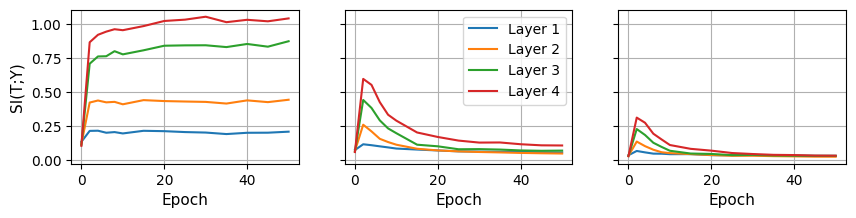

In [88]:
fig, axs =  plt.subplots(1, 3, figsize=(10, 2), dpi=100, sharey=True)
for layer in range(1,5):
    axs[0].plot(saved_epoch_list, all_smi_layers[0][layer])
axs[0].set_xlabel('Epoch', fontsize=11)
axs[0].set_ylabel('SI(T;Y)', fontsize=11)
axs[0].grid(True)
for layer in range(1,5):
    axs[1].plot(saved_epoch_list, all_smi_layers[1][layer], label=f'Layer {layer}')
axs[1].legend(loc='upper right')
axs[1].set_xlabel('Epoch', fontsize=11)
axs[1].grid(True)
for layer in range(1,5):
    axs[2].plot(saved_epoch_list, all_smi_layers[2][layer])
axs[2].set_xlabel('Epoch', fontsize=11)
axs[2].grid(True)
plt.show()